<a href="https://colab.research.google.com/github/stazam/Datamining2-project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling1D, Flatten, Dropout
from keras import optimizers

In [2]:
from google.colab import files 

uploaded = files.upload()

Saving sciencetech_articles.npy to sciencetech_articles.npy
Saving sport_articles.npy to sport_articles.npy
Saving travel_articles.npy to travel_articles.npy


## Importing scraped articles from dailymail page

In [3]:
science = np.load('sciencetech_articles.npy',allow_pickle='TRUE').item()
sport = np.load('sport_articles.npy',allow_pickle='TRUE').item()
travel = np.load('travel_articles.npy',allow_pickle='TRUE').item()

In [4]:
print("There is %d articles from science category" % (len(science)))
print("There is %d articles from sport category" % (len(sport)))
print("There is %d articles from travel category" % (len(travel)))

There is 136 articles from science category
There is 273 articles from sport category
There is 124 articles from travel category


## Data preprocessing - text into lower, removing blank spaces,...

In [5]:
def preprocess_articles(articles) -> list:

  articles_preprocess = []

  for key,value in articles.items():
    list_temp = []
    list_temp.append(key)
    for text in value:
      if len(text) > 0:
        list_temp.append(text.lower().strip().rstrip())
    articles_preprocess.append(list_temp)

  articles_preprocess = [' '.join(item) for item in articles_preprocess]

  return articles_preprocess 

In [6]:
sport = preprocess_articles(sport)
labels_sport = [0] * len(sport)

travel = preprocess_articles(travel)
labels_travel = [1] * len(travel)

science = preprocess_articles(science)
labels_science = [2] * len(science)

articles = sport + travel + science
labels =  labels_sport + labels_travel + labels_science

In [7]:
print('We have all %d articles alltogether' % len(labels))

We have all 533 articles alltogether


We are splitting our data into training and testing set

In [45]:
X_train, X_test, y_train, y_test = train_test_split(articles, labels, test_size=0.33, random_state=42)

Next we use tokenizer to rewrite our sentences into sequences of numbers.


In [9]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
vocab_size = 10700

In [46]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = np.array(pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = np.array(pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

If we want to save tokenizer, we culd do it in this way.


In [11]:
import pickle

# saving
with open('tokenizer_articles.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer_articles.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

#Modeling 
Now we choode model architecture, which brings the best results in terms of lowest value of loss function and best accuracy on test set. 

Since we are working with sequentianal / text data we use RNN netwrorks.


In [12]:
model = tf.keras.Sequential()

model.add(Embedding(vocab_size,240, input_length = max_length))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Flatten()),
Dropout(0.5),
model.add(Dense(3,activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 240)         2568000   
                                                                 
 bidirectional (Bidirectiona  (None, 5000, 128)        156160    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 5000, 64)         41216     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 3)                 960003    
                                                                 
Total params: 3,725,379
Trainable params: 3,725,379
Non-

In [13]:
history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test), verbose = 1)

Epoch 1/5
12/12 [==============================] - 38s 2s/step - loss: 1.8974 - accuracy: 0.4426 - val_loss: 1.1442 - val_accuracy: 0.4205
Epoch 2/5
12/12 [==============================] - 25s 2s/step - loss: 0.6598 - accuracy: 0.7367 - val_loss: 0.5491 - val_accuracy: 0.7727
Epoch 3/5
12/12 [==============================] - 25s 2s/step - loss: 0.2523 - accuracy: 0.9188 - val_loss: 0.3232 - val_accuracy: 0.8636
Epoch 4/5
12/12 [==============================] - 25s 2s/step - loss: 0.0480 - accuracy: 0.9916 - val_loss: 0.2003 - val_accuracy: 0.9318
Epoch 5/5
12/12 [==============================] - 25s 2s/step - loss: 0.0144 - accuracy: 0.9972 - val_loss: 0.1948 - val_accuracy: 0.9205


Saving the model for our project.

In [14]:
model.save('model.h5')
print('Model Saved!')
 
# load model
# savedModel=load_model('model_articles.h5')
# savedModel.summary()

Model Saved!


We could also try a more advanced architecture as the one below, but we got good results with the previous model.

In [15]:
# model1 = Sequential([
#     Embedding(vocab_size, 512, input_length=max_length),
#     Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
#     Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
#     Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
#     Dropout(0.5),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(24, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])
# model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# num_epochs = 5
# history = model1.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))

Plot the model results, i.e. loss functions value and accuracy during all epochs.

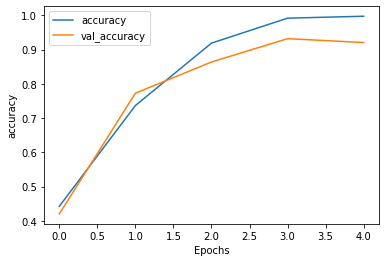

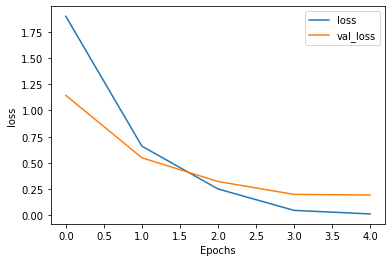

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We will try the classifier on some random text.


In [17]:
sentence = ["I am sport article about football  game"]

In [18]:
def predict_category(text, tokenizer, model):

    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    return  model.predict(padded)[0].tolist()

In [19]:
predict_category(sentence, tokenizer, model)

[0.9592591524124146, 0.028562674298882484, 0.012178265489637852]

We finally look at the confusion matrix of test set.


In [47]:
def replace_num(arr):

  arr = arr.astype('object')
  arr[arr == 0] = 'sport'
  arr[arr == 1] = 'travel'
  arr[arr == 2] = 'science'

  return arr

y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = replace_num(y_pred)

y_test = np.argmax(y_test, axis = 1)
y_test = replace_num(y_test)

print(metrics.confusion_matrix(y_test, y_pred, labels=["sport", "travel", "science"]))

[[85  4  0]
 [ 1 33  3]
 [ 0  6 44]]
